# Benchmark SGD Implementations  
In this iPython notebook, we benchmark the Parallel implementaton of SGD against the implementation in SciKit-Learn library. We will use SGD in both cases for regression on synthetic data.   

**Credits**  
1. The parallel implementation here is based on this paper: Zinkevich, M., Weimer, M., Li, L., & Smola, A. (2010). Parallelized stochastic gradient descent. Advances in Neural Information Processing Systems, 1–36. Retrieved from http://papers.nips.cc/paper/4006-parallelized-stochastic-gradient-descent 
2. Niu, F., Recht, B., Re, C., & Wright, S. J. (2011). HOGWILD!: A Lock-Free Approach to Parallelizing Stochastic Gradient Descent. Advances in Neural Information Processing Systems, (1), 21. Retrieved from http://arxiv.org/abs/1106.5730 

## The Dataset  
The dataset will be generated using SciKit-Learn's `make_regression` function.  

In [1]:
from sklearn.datasets import make_regression
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import time

In [2]:
n_samples = 1000
n_features = 1000
seed = 1
effective_rank = 100

In [3]:
X, y = make_regression(n_samples=n_samples, n_features=n_features, 
                       random_state=seed, noise=0.0, 
                       effective_rank=effective_rank)

Split the dataset into train and test

In [4]:
from sklearn.cross_validation import ShuffleSplit

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
for train, test in ShuffleSplit(n=n_samples, n_iter=1, test_size=0.2):
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]

## SciKit-Learn SGD

In [6]:
from sklearn.linear_model import SGDRegressor

In [7]:
n_iter = 5000

In [8]:
sgd = SGDRegressor(n_iter=n_iter, warm_start=True)

start_time = time.time()
sgd.fit(X_train, y_train)
time1 = time.time() - start_time

print "Baseline time: %0.2f seconds" % time1

score1 = sgd.score(X_test, y_test)
print "Baseline score: %0.2f" % score1

Baseline time: 13.70 seconds
Baseline score: 0.26


## Parallel SGD
Parallel implementation of SGD based on the simulation results from previous section

In [9]:
from multiprocessing import Pool
import utils
import math
from joblib import Parallel, delayed

In [10]:
num_procs = 4
t_iter = 1

### PSDG1 Performance
Parallel SGD with reduced iterations per worker and one sync at the end. Iterations are split evenly amongst all workers

In [11]:
speedup_acc_1 = []

for n_jobs in range(1, num_procs+1):
    n_iter_per_job = n_iter/n_jobs
    start_time = time.time()
    for _ in range(t_iter):
        sgd = utils.psgd_1(SGDRegressor(), n_iter_per_job, n_jobs, X_train, y_train)
    elapsed_time = (time.time() - start_time)/t_iter
    speedup_acc_1 += [[time1/elapsed_time, sgd.score(X_test, y_test)]]

speedup_acc_1 = np.array(speedup_acc_1).T

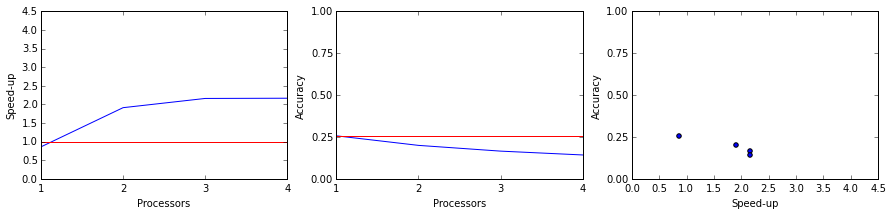

In [36]:
utils.plot_speedup_acc(speedup_acc_1, score1)

### PSG2 Performance
Parallel SGD with reduced iterations per worker and multiple syncs throughout the iterations. Iterations are split evenly amongst all workers. There are as many syncs as there are workers.

In [37]:
speedup_acc_2 = []

for n_jobs in range(1, num_procs+1):
    n_iter_per_job = n_iter/n_jobs
    start_time = time.time()
    for _ in range(t_iter):
        sgd = utils.psgd_2(SGDRegressor(), n_iter_per_job, n_jobs, 10, X_train, y_train)
    elapsed_time = (time.time() - start_time)/t_iter
    speedup_acc_2 += [[time1/elapsed_time, sgd.score(X_test, y_test)]]

speedup_acc_2 = np.array(speedup_acc_2).T

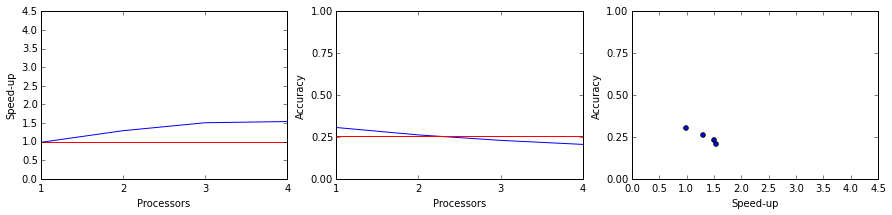

In [38]:
utils.plot_speedup_acc(speedup_acc_2, score1)

### PSG3 Performance
Parallel SGD with reduced iterations per worker, multiple syncs, and increased learning rate per worker. Iterations are split evenly amongst all workers. There are as many syncs as there are workers. The learning rate is increased by a factor of the number of workers.

In [39]:
speedup_acc_3 = []

for n_jobs in range(1, num_procs+1):
    n_iter_per_job = n_iter/n_jobs
    start_time = time.time()
    for _ in range(t_iter):
        sgd = utils.psgd_3(SGDRegressor(), n_iter_per_job, n_jobs, 10, X_train, y_train)
    elapsed_time = (time.time() - start_time)/t_iter
    speedup_acc_3 += [[time1/elapsed_time, sgd.score(X_test, y_test)]]

speedup_acc_3 = np.array(speedup_acc_3).T

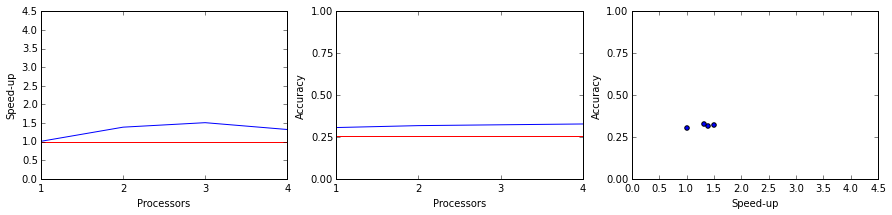

In [40]:
utils.plot_speedup_acc(speedup_acc_3, score1)

### PSG4 Performance
Parallel SGD with reduced iterations per worker and shared weights. This is implemented using threading and shared memory. Iterations are split evenly amongst all workers. Each worker reads the weights from a shared memory, processes them, and overwrites it. 

In [41]:
speedup_acc_4 = []

for n_jobs in range(1, 5):
    n_iter_per_job = n_iter/n_jobs
    start_time = time.time()
    for _ in range(t_iter):
        coef = np.random.sample(size=(X_train.shape[1],))
        intercept = np.random.sample(size=(1,))
        sgd = utils.psgd_4(SGDRegressor(), 
                       n_iter_per_job, n_jobs, 
                       X_train, y_train, 
                       coef, intercept)
    elapsed_time = (time.time() - start_time)/t_iter
    speedup_acc_4 += [[time1/elapsed_time, sgd.score(X_test, y_test)]]

speedup_acc_4 = np.array(speedup_acc_4).T

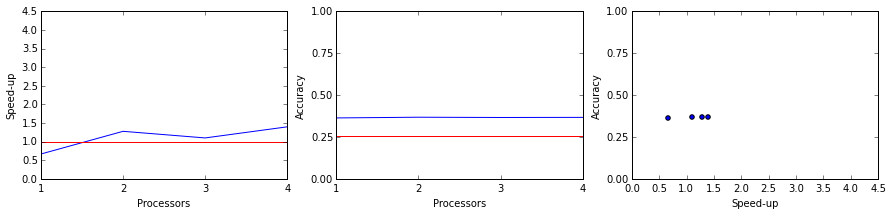

In [42]:
utils.plot_speedup_acc(speedup_acc_4, score1)

### PSG5 Performance
Similar to PSGD4, but with parallelization implemented at a lower level -- at the lowest Python level possible.  
Parallel SGD with reduced iterations per worker and shared weights. This is implemented using threading and shared memory. Iterations are split evenly amongst all workers. Each worker reads the weights from a shared memory, processes them, and overwrites it. 

In [44]:
speedup_acc_5 = []

for n_jobs in range(1, num_procs+1):
    n_iter_per_job = n_iter/n_jobs
    start_time = time.time()
    sgd = SGDRegressor(n_iter=n_iter, warm_start=True, n_jobs=n_jobs)
    for _ in range(t_iter):
        sgd.fit(X_train, y_train)
    elapsed_time = (time.time() - start_time)/t_iter
    speedup_acc_5 += [[time1/elapsed_time, sgd.score(X_test, y_test)]]

speedup_acc_5 = np.array(speedup_acc_5).T

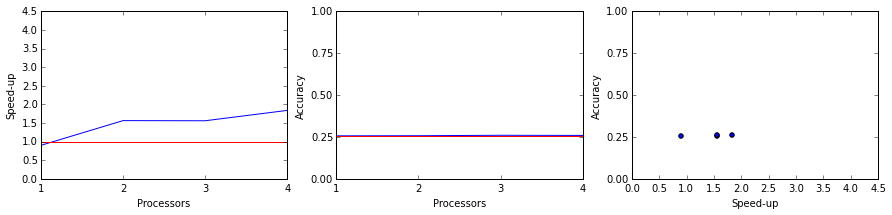

In [45]:
utils.plot_speedup_acc(speedup_acc_5, score1)